### Additional cleaning

#### iPhone

In [1]:
import pandas as pd
import numpy as np

df_iphone = pd.read_csv("data/iphone_cleaned.csv")

#additional cleaning needed as discovered during EDA (was originally done in R)
filtered_df_iphone = df_iphone[df_iphone["category_id"] == 9355]
filtered_df_iphone = filtered_df_iphone[filtered_df_iphone["price.value"] > 200]

#add discount flag
filtered_df_iphone['discount_flag'] = (~filtered_df_iphone['marketingPrice.discountPercentage'].isna()) \
                                    & (filtered_df_iphone['marketingPrice.discountPercentage'] != "")
#more cleaning
filtered_df_iphone["condition"] = filtered_df_iphone["condition"].replace("Usato", "Used")
filtered_df_iphone["category_name"] = filtered_df_iphone["category_name"].replace("Cellulari e smartphone", "Cell Phones & Smartphones")
filtered_df_iphone['condition_desc'] = filtered_df_iphone['conditionId'].astype(str) + " - " + filtered_df_iphone['condition']
filtered_df_iphone["shipping_cost"] = filtered_df_iphone["shipping_cost"].fillna(0)

#more info from title
import re
filtered_df_iphone["specific_carrier"] = filtered_df_iphone["title"].str.extract(r'(\b[\w\-\&]+)\s+only', flags=re.IGNORECASE).fillna("no_carrier")
filtered_df_iphone["unlocked"] = filtered_df_iphone["title"].str.lower().str.contains("unlocked").fillna(False)
filtered_df_iphone["title_length"] = filtered_df_iphone["title"].str.len()
#filtered_df_iphone.head(2)

#summary
avg_prices = filtered_df_iphone.groupby('condition_desc')['price.value'].mean().reset_index(name='mean_price')
counts = filtered_df_iphone.groupby('condition_desc')['price.value'].count().reset_index(name='counts')
condition_summary = pd.merge(avg_prices, counts, on='condition_desc')
print(condition_summary)

filtered_df_iphone.to_csv("data/iphone_new.csv", index=False)

                    condition_desc  mean_price  counts
0                       1000 - New  727.180741      27
1                  1500 - Open box  633.705200      25
2   2010 - Excellent - Refurbished  566.922676      71
3   2020 - Very Good - Refurbished  550.840000     101
4        2030 - Good - Refurbished  479.655349      43
5                      3000 - Used  527.415221     113
6  7000 - For parts or not working  447.481667       6


#### Microwave

In [2]:
df_microwave = pd.read_csv("data/microwaves.csv")
df_microwave['sponsored'] = df_microwave['sponsored'].fillna(False)
df_microwave['is_small_business'] = df_microwave['is_small_business'].fillna(False)
df_microwave['has_coupon'] = df_microwave['coupon'].notna()
df_microwave['cu_ft'] = df_microwave['cu_ft'].fillna("unknown")
df_microwave['price_list_price'] = df_microwave['price_list_price'].str.replace("[$,]", "", regex=True).astype(float)
df_microwave['stock_info'] = df_microwave['stock_info'].fillna("None")
df_microwave["rating"] = df_microwave["rating"].fillna(0)
df_microwave["ratings_total"] = df_microwave["ratings_total"].fillna(0)
df_microwave.loc[df_microwave["price_list_price"] < df_microwave["price_value"], "price_list_price"] = np.nan
df_microwave["discount$"] = round(df_microwave["price_list_price"] - df_microwave["price_value"], 2)
df_microwave["discount%"] = round(df_microwave["discount$"] / df_microwave["price_list_price"], 2)
df_microwave["discount$"] = df_microwave["discount$"].fillna(0)
df_microwave["discount%"] = df_microwave["discount%"].fillna(0)

df_microwave.to_csv("data/microwave_new.csv", index=False)


/var/folders/vg/bxzl7hss0gs1hqxsc9zj92l80000gn/T/ipykernel_3113/1523889666.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_microwave['sponsored'] = df_microwave['sponsored'].fillna(False)
/var/folders/vg/bxzl7hss0gs1hqxsc9zj92l80000gn/T/ipykernel_3113/1523889666.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_microwave['is_small_business'] = df_microwave['is_small_business'].fillna(False)


### KMeans

#### iPhones

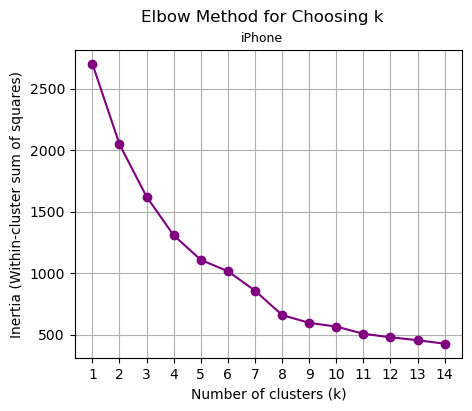

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import itertools
import math

# Select features, quantitative only
features = filtered_df_iphone[["seller.feedbackPercentage", "seller.feedbackScore", 
                               "days_listed", "shipping_cost", "seller_item_count",
                                "additional_image_count", "title_length"]].fillna(0)

# Scale
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

#elbow plot
k_range = range(1, 15)
inertias = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertias.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(5, 4))
plt.plot(k_range, inertias, marker='o', color="purple")
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.suptitle('Elbow Method for Choosing k')
plt.text(0.5, 0.90, "iPhone", fontsize=9, ha='center', transform=plt.gcf().transFigure)
plt.xticks(k_range)
plt.grid(True)
plt.savefig("images/2/elbow_iphone.png", dpi=300, bbox_inches='tight')
plt.show()

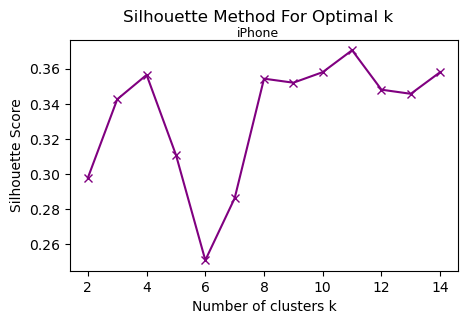

In [4]:
from sklearn.metrics import silhouette_score

sil_scores = []
K = range(2, 15)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(features_scaled)
    score = silhouette_score(features_scaled, labels)
    sil_scores.append(score)

plt.figure(figsize=(5,3))
plt.plot(K, sil_scores, 'x-', color="purple")
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette Score')
plt.suptitle('Silhouette Method For Optimal k')
plt.text(0.5, 0.89, "iPhone", fontsize=9, ha='center', transform=plt.gcf().transFigure)
plt.savefig("images/2/silh_iphone.png", dpi=300, bbox_inches='tight')
plt.show()

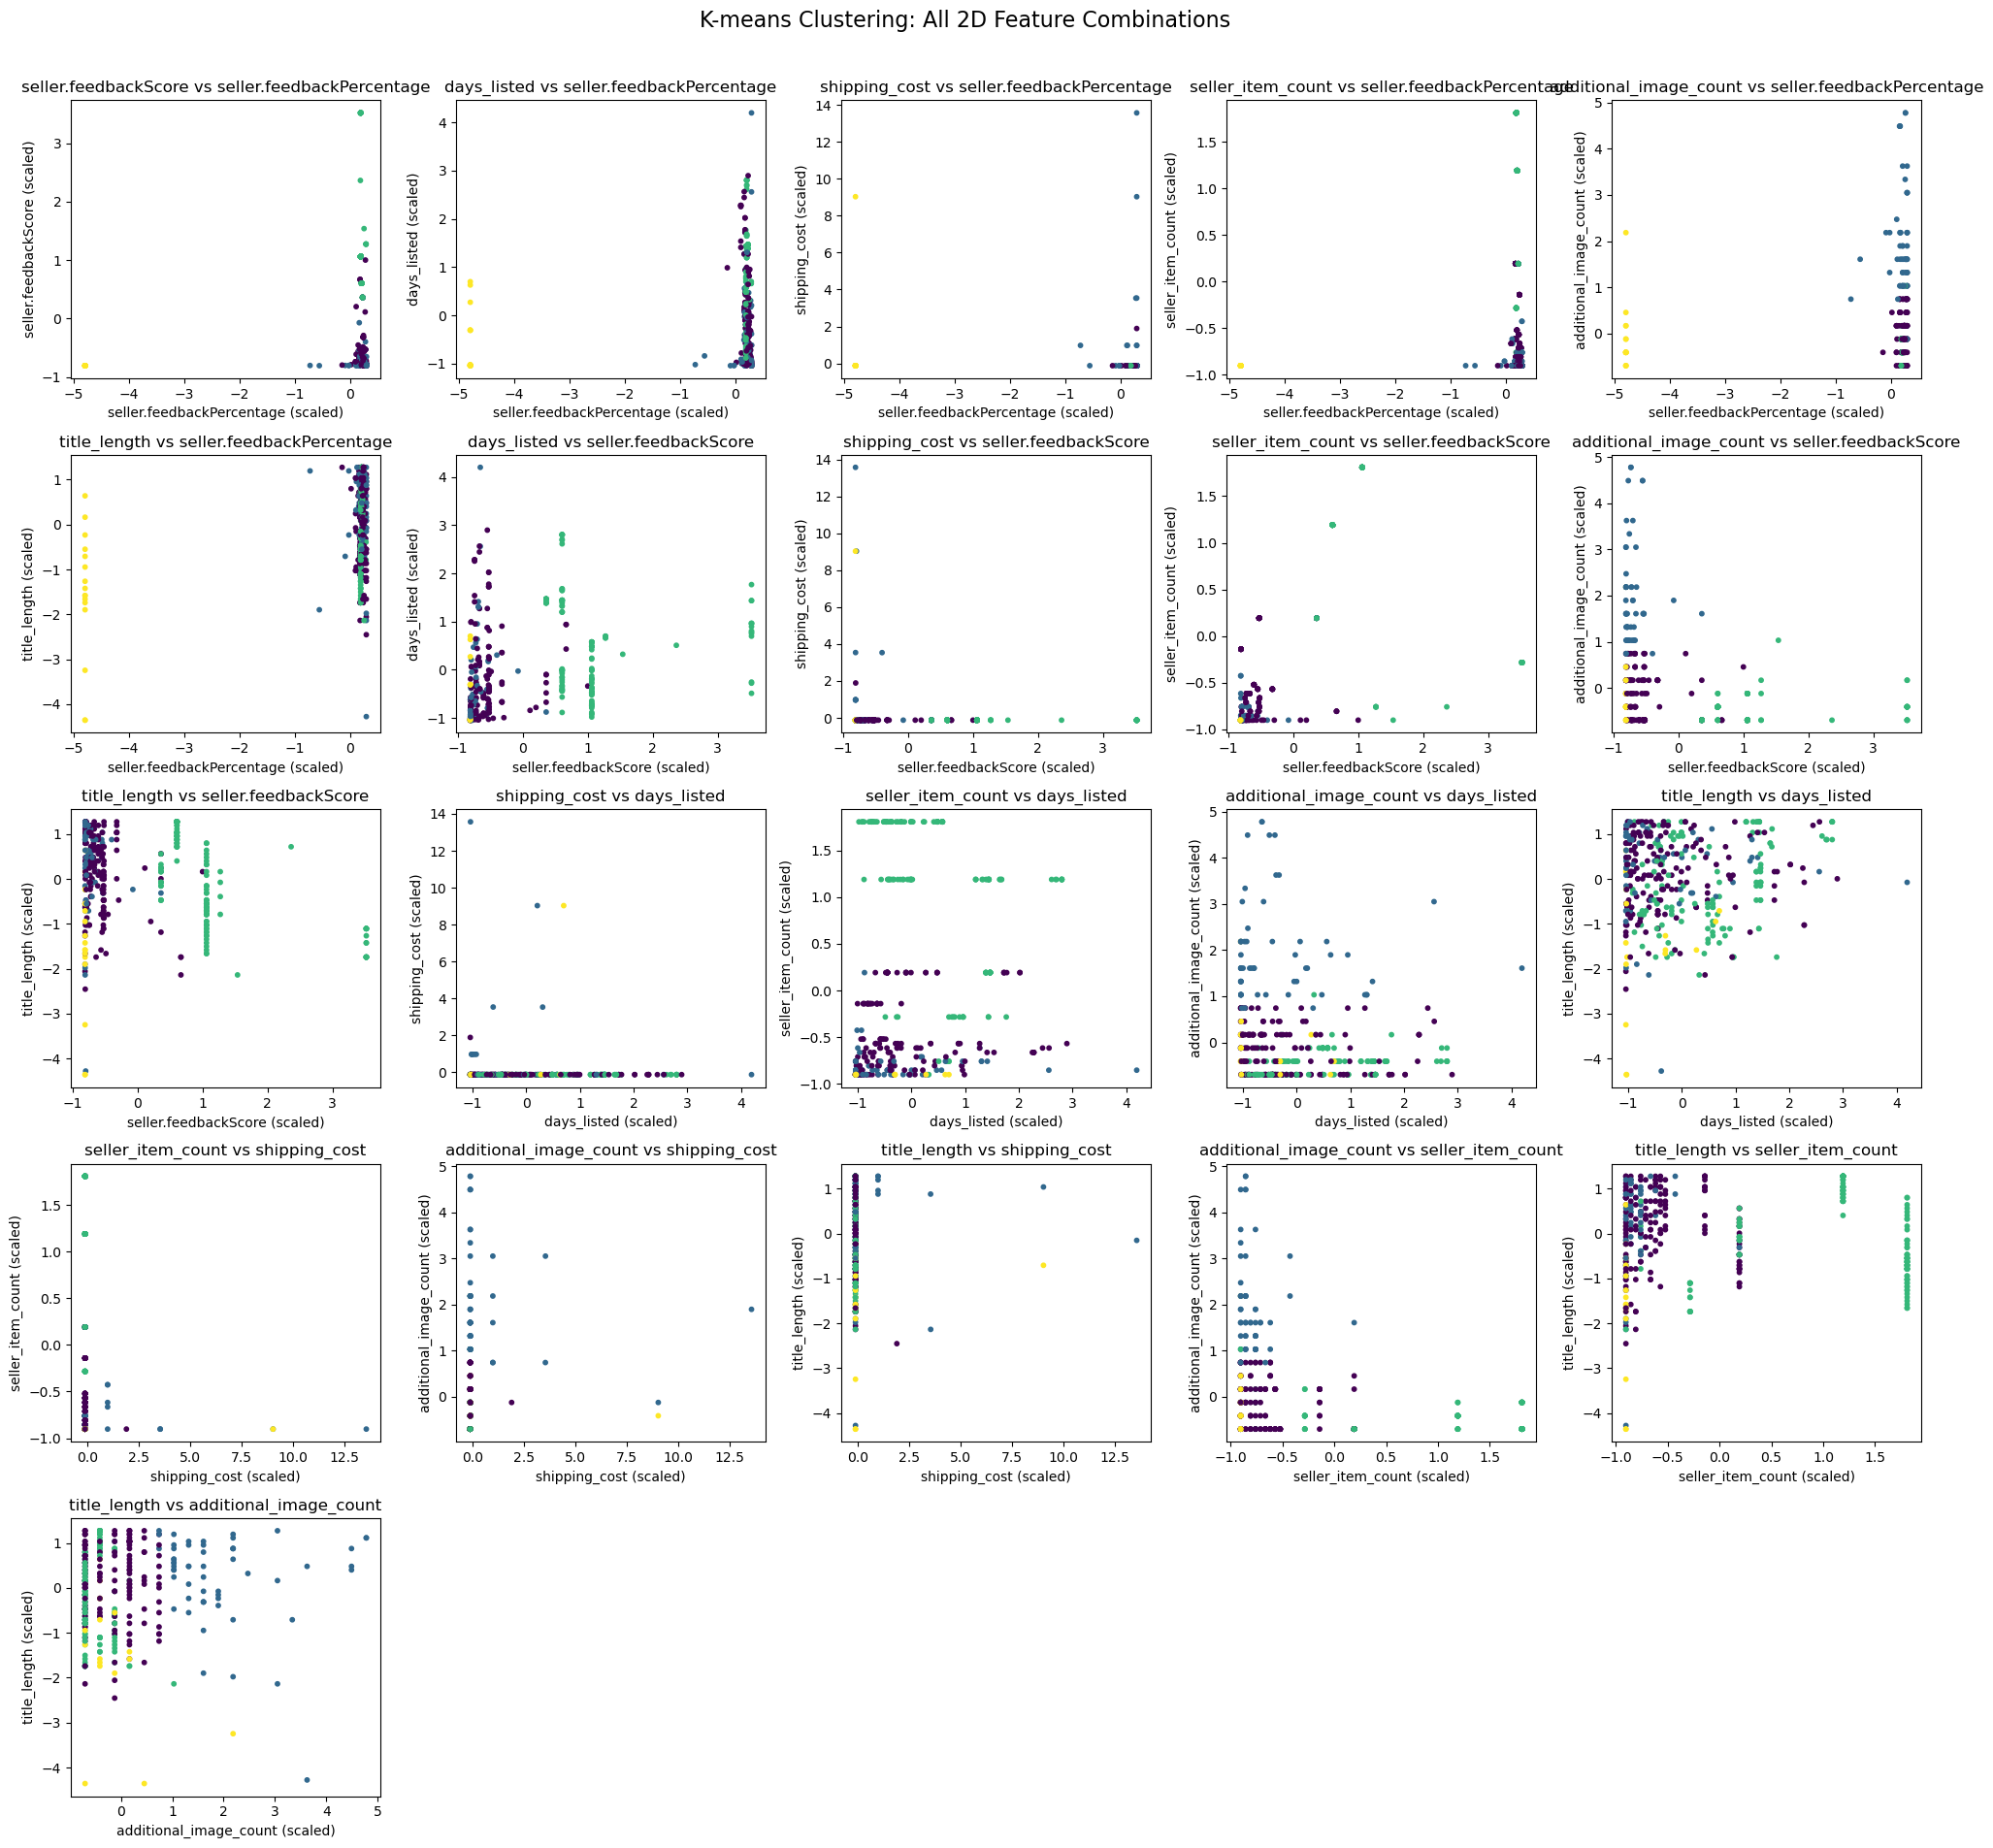

In [5]:
# K-means
kmeans = KMeans(n_clusters=4, random_state=1216)
filtered_df_iphone["k_cluster"] = kmeans.fit_predict(features_scaled)

combinations = list(itertools.combinations(features.columns, 2))
n_plots = len(combinations)
n_cols = 5
n_rows = math.ceil(n_plots / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))
axes = axes.flatten()

col_index = {col: i for i, col in enumerate(features.columns)}
for idx, (x_col, y_col) in enumerate(combinations):
    ax = axes[idx]
    x_idx = col_index[x_col]
    y_idx = col_index[y_col]
    ax.scatter(features_scaled[:, x_idx], features_scaled[:, y_idx], c=filtered_df_iphone['k_cluster'], cmap='viridis', s=10)
    ax.set_xlabel(f'{x_col} (scaled)')
    ax.set_ylabel(f'{y_col} (scaled)')
    ax.set_title(f'{y_col} vs {x_col}')

# Hide unused subplots if any
for k in range(len(combinations), len(axes)):
    axes[k].axis('off')

fig.suptitle('K-means Clustering: All 2D Feature Combinations', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

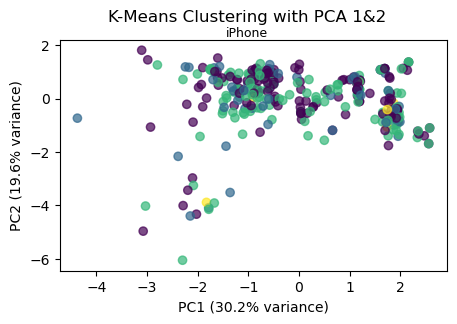

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(features_scaled)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['k_cluster'] = filtered_df_iphone['k_cluster']

explained_var = pca.explained_variance_ratio_

plt.figure(figsize=(5, 3))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['k_cluster'], cmap='viridis', alpha=0.7)
plt.xlabel(f"PC1 ({explained_var[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({explained_var[1]*100:.1f}% variance)")
plt.suptitle('K-Means Clustering with PCA 1&2')
plt.text(0.5, 0.89, "iPhone", fontsize=9, ha='center', transform=plt.gcf().transFigure)
plt.savefig("images/2/kmeans_wPCA_iphone.png", dpi=300, bbox_inches='tight', facecolor="#E7E7E7")
plt.show()

In [7]:
cluster_summary = filtered_df_iphone.groupby("k_cluster")[["seller.feedbackPercentage", "seller.feedbackScore", 
                               "days_listed", "shipping_cost", "seller_item_count",
                               "additional_image_count", "title_length"]].agg(["mean", "count"]).round(2)
cluster_summary
#cluster_summary.to_excel("working_files/iphone_cluster_sum.xlsx")

seller.feedbackPercentage       seller.feedbackScore        \
                               mean count                 mean count   
k_cluster                                                              
0                             98.50   173             18855.28   173   
1                             97.99    58              8690.69    58   
2                             98.24   139            155949.35   139   
3                              0.00    16                 7.44    16   

          days_listed       shipping_cost       seller_item_count        \
                 mean count          mean count              mean count   
k_cluster                                                                 
0              194.39   173          0.03   173              8.73   173   
1              171.93    58          1.68    58              3.29    58   
2              357.45   139          0.00   139             43.09   139   
3              105.50    16          1.56    16              1.00    16   

          additional_image_count       title_length        
                            mean count         mean count  
k_cluster                                                  
0                           1.57   173        65.36   173  
1                           9.10    58        66.97    58  
2                           0.74   139        63.12   139  
3                           1.94    16        44.44    16

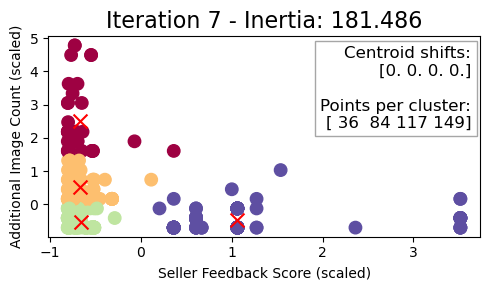

In [8]:
#animated gif
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

X_raw = filtered_df_iphone[["seller.feedbackScore", "additional_image_count"]].values
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)
fig, ax = plt.subplots(figsize=(5,3))
k = 4
km = KMeans(n_clusters=k, init='random', n_init=1, max_iter=1, random_state=1)
centers_prev = None

def update(i):
    global km, centers_prev
    ax.clear()
    if i == 0:
        labels = np.random.randint(0, k, size=X.shape[0])
        ax.scatter(X[:,0], X[:,1], c=labels, cmap='Spectral', s=80)
        ax.set_title('Random labels', fontsize=16)
        centers_prev = None
        inertia = np.nan
        shifts = [0]*k
        counts = [0]*k
    else:
        if i == 1:
            km.fit(X)
        else:
            km = KMeans(n_clusters=k, init=km.cluster_centers_, n_init=1, max_iter=1, random_state=1)
            km.fit(X)
        labels = km.labels_
        centers = km.cluster_centers_
        inertia = km.inertia_
        if centers_prev is None:
            shifts = [0]*k
        else:
            shifts = np.linalg.norm(centers - centers_prev, axis=1)
        centers_prev = centers.copy()
        counts = np.bincount(labels, minlength=k)
        ax.scatter(X[:,0], X[:,1], c=labels, cmap='Spectral', s=80)
        ax.scatter(centers[:,0], centers[:,1], color='red', marker='x', s=100)
        ax.set_title(f"Iteration {i} - Inertia: {inertia:.3f}", fontsize=16)

    ax.set_xlabel("Seller Feedback Score (scaled)")
    ax.set_ylabel("Additional Image Count (scaled)")

    # Show centroid shifts and cluster sizes inside plot area, top-right
    info_text = f"Centroid shifts:\n{np.round(shifts,3)}\n\nPoints per cluster:\n{counts}"
    ax.text(0.98, 0.95, info_text, transform=ax.transAxes,
            fontsize=12, verticalalignment='top', horizontalalignment='right',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))
    plt.tight_layout()
    return ax.collections

anim = FuncAnimation(fig, update, frames=8, interval=1000, blit=False)
from matplotlib.animation import PillowWriter
anim.save('images/2/kmeans.gif', writer=PillowWriter(fps=1))
plt.show()

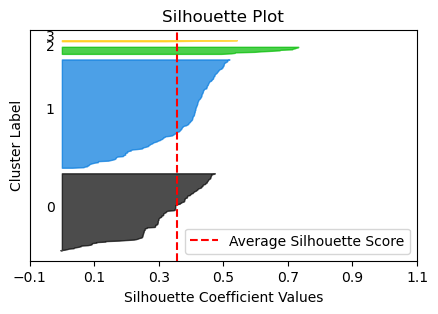

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
import numpy as np

# Assuming features_scaled is your preprocessed data
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(features_scaled)

# Calculate silhouette scores for each sample
silhouette_vals = silhouette_samples(features_scaled, cluster_labels)

fig, ax = plt.subplots(figsize=(5, 3))

y_lower = 10  # For spacing between silhouette plots of each cluster
for i in range(k):
    # Aggregate silhouette scores for cluster i
    ith_cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
    ith_cluster_silhouette_vals.sort()

    size_cluster_i = ith_cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / k)
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                     0, ith_cluster_silhouette_vals,
                     facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with cluster numbers in the middle
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10  # 10 for spacing between clusters

ax.set_title("Silhouette Plot")
ax.set_xlabel("Silhouette Coefficient Values")
ax.set_ylabel("Cluster Label")

ax.axvline(x=np.mean(silhouette_vals), color="red", linestyle="--", label="Average Silhouette Score")

ax.set_yticks([])  # Clear y-axis labels/ticks
ax.set_xticks(np.arange(-0.1, 1.1, 0.2))
ax.legend()
plt.savefig("images/2/silh_plot_iphone.png", dpi=300, bbox_inches='tight')
plt.show()

In [10]:
import numpy as np
from sklearn.metrics import silhouette_samples

# Get silhouette score per sample
silhouette_vals = silhouette_samples(features_scaled, cluster_labels)

# Compute average per cluster
for cluster in np.unique(cluster_labels):
    avg_score = silhouette_vals[cluster_labels == cluster].mean()
    print(f"Cluster {cluster}: average silhouette score = {avg_score:.3f}")


Cluster 0: average silhouette score = 0.315
Cluster 1: average silhouette score = 0.365
Cluster 2: average silhouette score = 0.643
Cluster 3: average silhouette score = 0.430


#### Soccer (added later)

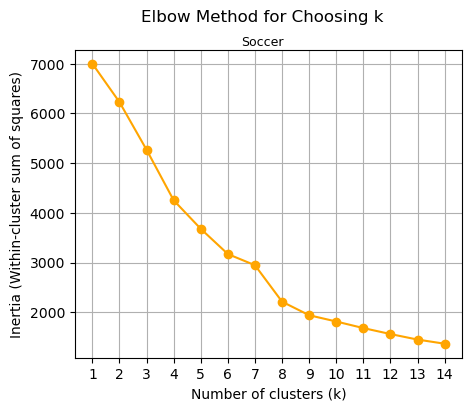

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import itertools
import math

df_soccer = pd.read_csv("data/soccer_kmc.csv")

features_soccer = df_soccer[["seller.feedbackPercentage", "seller.feedbackScore", 
                               "days_listed", "shipping_cost", "seller_item_count",
                                "additional_image_count", "title_length"]].fillna(0)

# Scale
scaler = StandardScaler()
features_soccer_scaled = scaler.fit_transform(features_soccer)

#elbow plot
k_range = range(1, 15)
inertias = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_soccer_scaled)
    inertias.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(5, 4))
plt.plot(k_range, inertias, marker='o', color="orange")
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.suptitle('Elbow Method for Choosing k')
plt.text(0.5, 0.89, "Soccer", fontsize=9, ha='center', transform=plt.gcf().transFigure)
plt.xticks(k_range)
plt.grid(True)
plt.savefig("images/2/elbow_soccer.png", dpi=300, bbox_inches='tight')
plt.show()

/var/folders/vg/bxzl7hss0gs1hqxsc9zj92l80000gn/T/ipykernel_3113/438518053.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(K, sil_scores, 'bx-', color="orange")


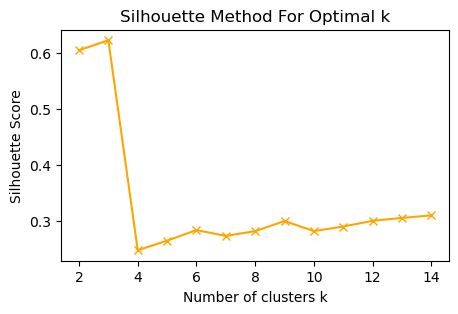

In [12]:
from sklearn.metrics import silhouette_score

sil_scores = []
K = range(2, 15)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(features_soccer_scaled)
    score = silhouette_score(features_soccer_scaled, labels)
    sil_scores.append(score)

plt.figure(figsize=(5,3))
plt.plot(K, sil_scores, 'bx-', color="orange")
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method For Optimal k')
plt.savefig("images/2/silh_soccer.png", dpi=300, bbox_inches='tight')
plt.show()

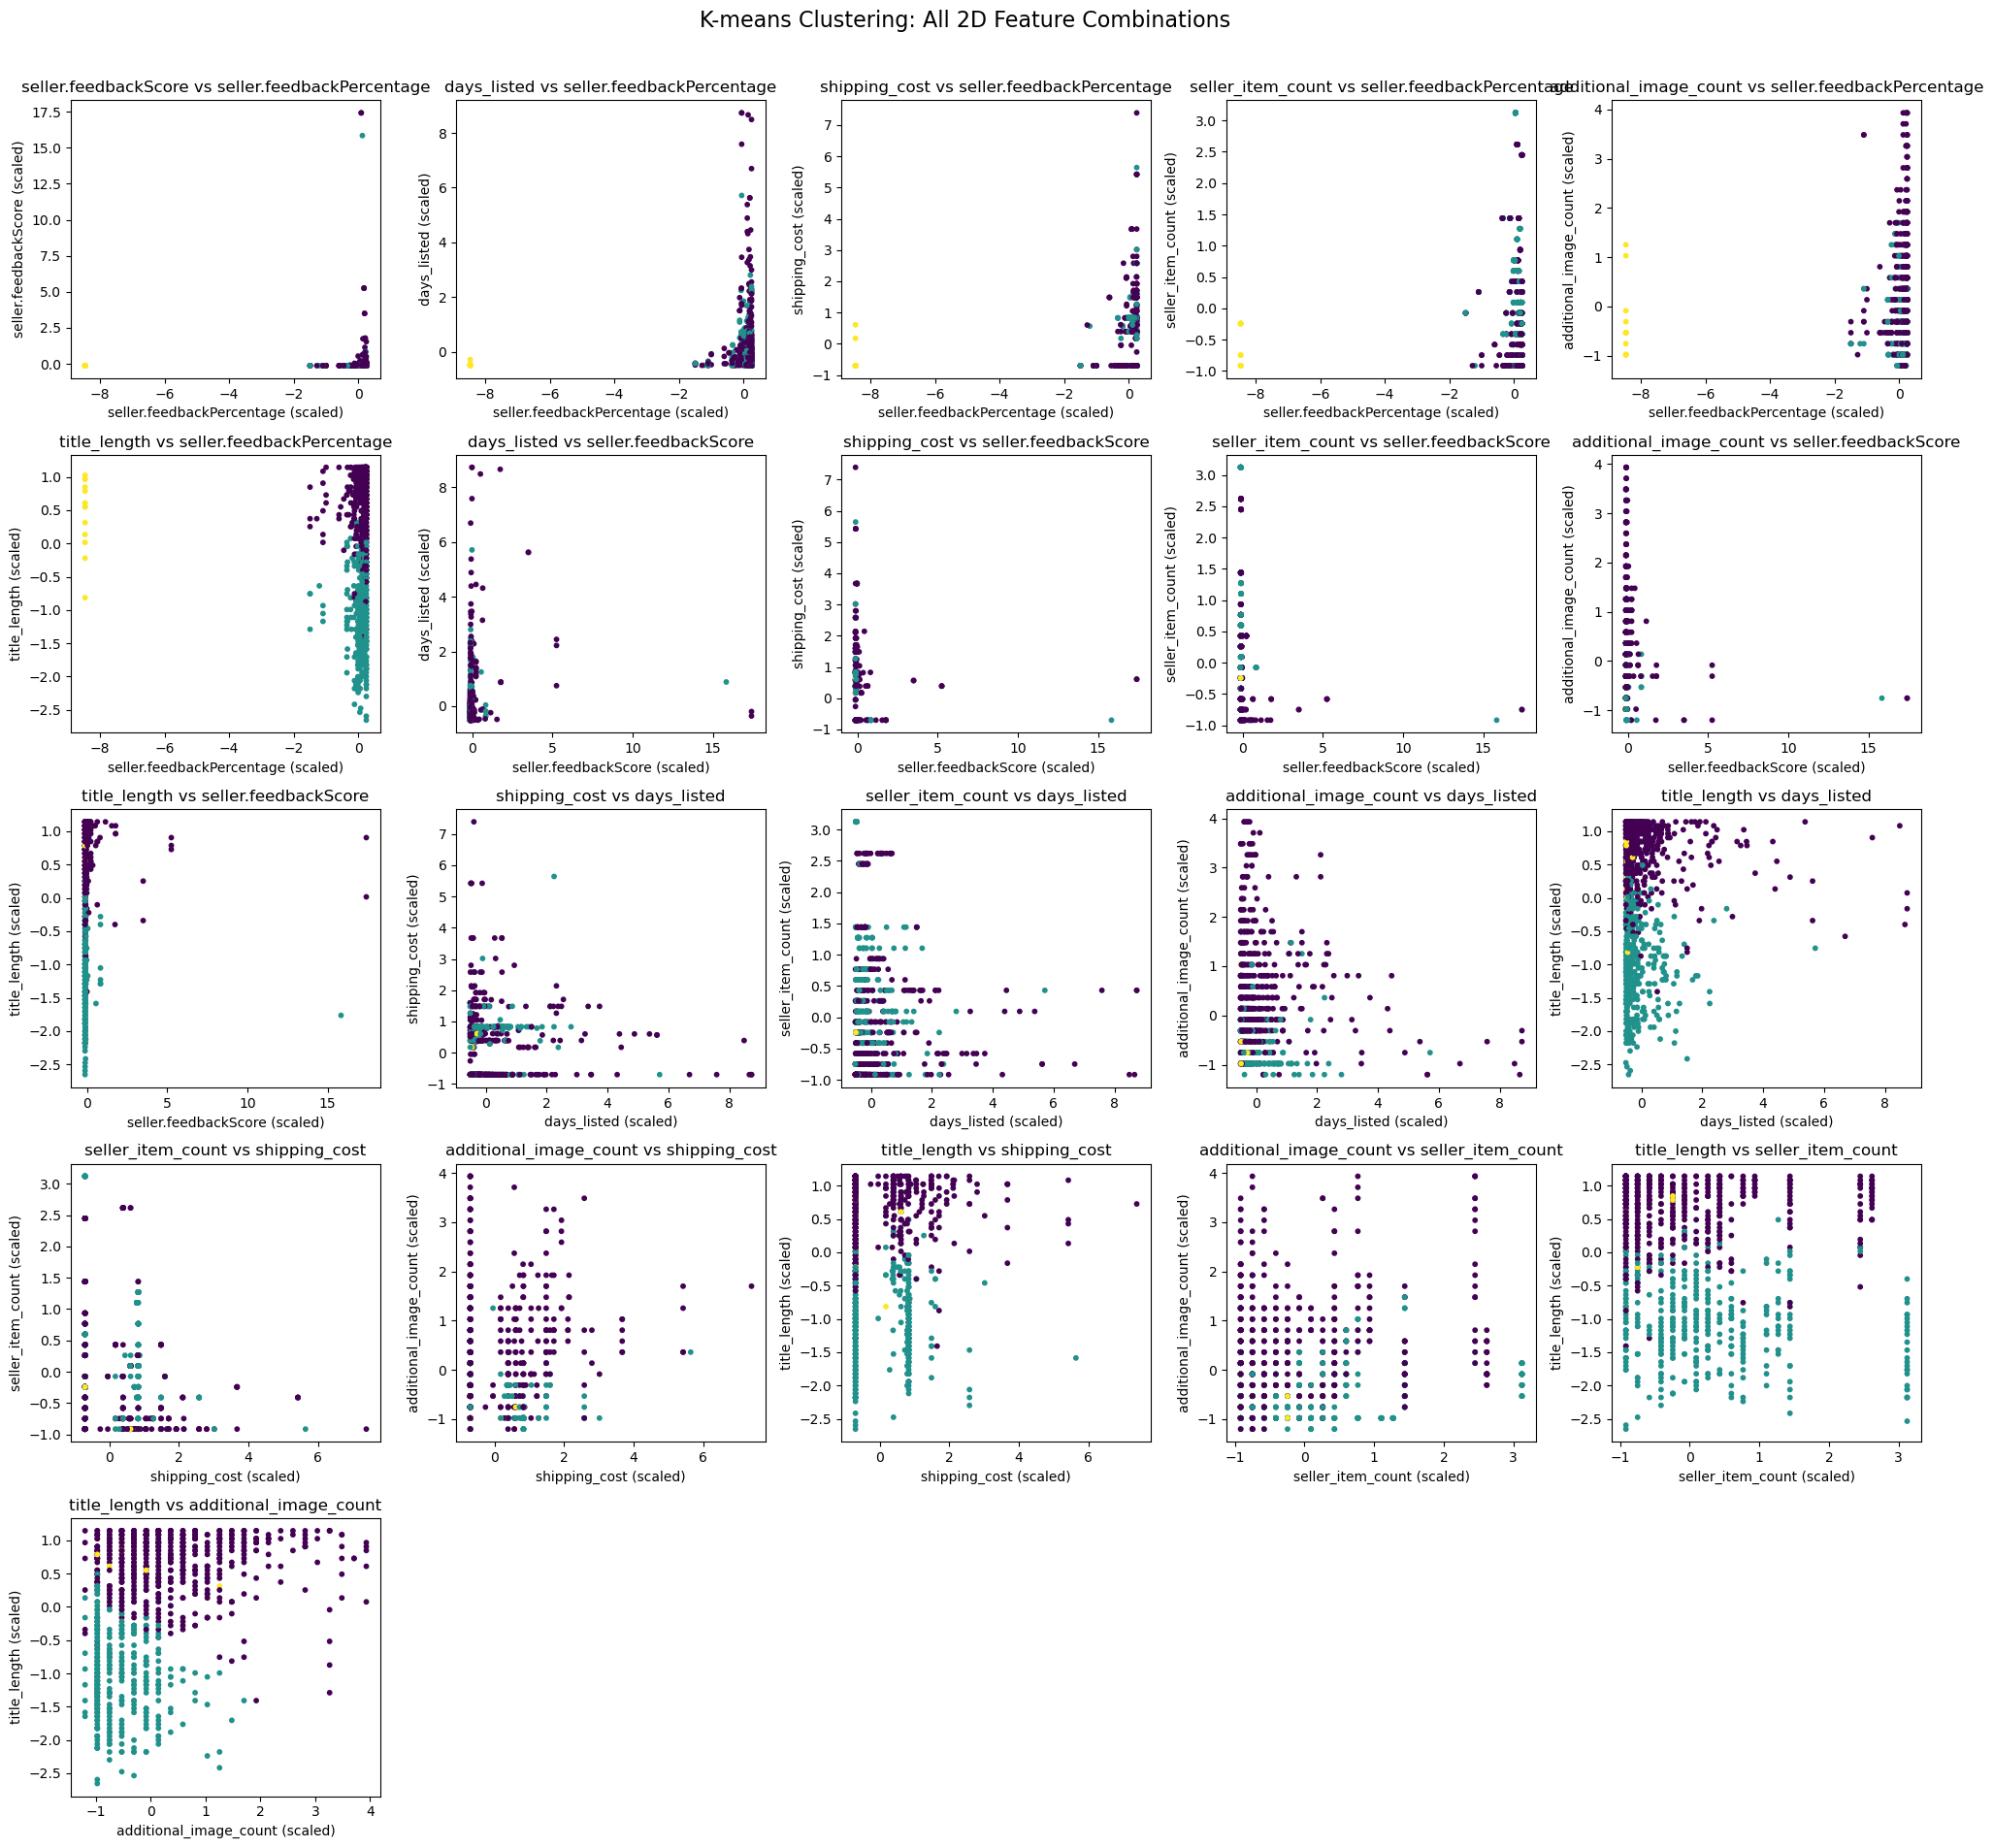

In [13]:
# K-means
kmeans = KMeans(n_clusters=3, random_state=1216)
df_soccer["k_cluster"] = kmeans.fit_predict(features_soccer_scaled)

combinations = list(itertools.combinations(features_soccer.columns, 2))
n_plots = len(combinations)
n_cols = 5
n_rows = math.ceil(n_plots / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))
axes = axes.flatten()

col_index = {col: i for i, col in enumerate(features_soccer.columns)}
for idx, (x_col, y_col) in enumerate(combinations):
    ax = axes[idx]
    x_idx = col_index[x_col]
    y_idx = col_index[y_col]
    ax.scatter(features_soccer_scaled[:, x_idx], features_soccer_scaled[:, y_idx], c=df_soccer['k_cluster'], cmap='viridis', s=10)
    ax.set_xlabel(f'{x_col} (scaled)')
    ax.set_ylabel(f'{y_col} (scaled)')
    ax.set_title(f'{y_col} vs {x_col}')

# Hide unused subplots if any
for k in range(len(combinations), len(axes)):
    axes[k].axis('off')

fig.suptitle('K-means Clustering: All 2D Feature Combinations', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

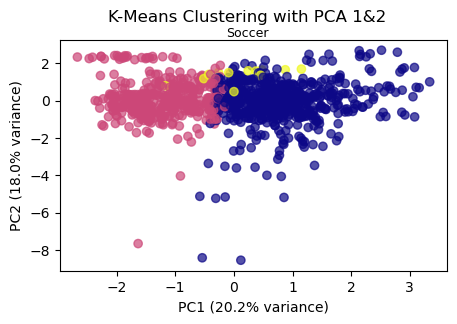

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(features_soccer_scaled)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['k_cluster'] = df_soccer['k_cluster']

explained_var = pca.explained_variance_ratio_

plt.figure(figsize=(5, 3))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['k_cluster'], cmap='plasma', alpha=0.7)
plt.xlabel(f"PC1 ({explained_var[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({explained_var[1]*100:.1f}% variance)")
plt.suptitle('K-Means Clustering with PCA 1&2')
plt.text(0.5, 0.89, "Soccer", fontsize=9, ha='center', transform=plt.gcf().transFigure)
plt.savefig("images/2/kmeans_wPCA_soccer.png", dpi=300, bbox_inches='tight', facecolor="#E7E7E7")
plt.show()

In [15]:
cluster_summary = df_soccer.groupby("k_cluster")[["seller.feedbackPercentage", "seller.feedbackScore", 
                               "days_listed", "shipping_cost", "seller_item_count",
                               "additional_image_count", "title_length"]].agg(["mean", "count"]).round(2)
cluster_summary
#cluster_summary.to_excel("working_files/soccer_cluster_sum.xlsx")

seller.feedbackPercentage       seller.feedbackScore        \
                               mean count                 mean count   
k_cluster                                                              
0                             98.53   594              5790.75   594   
1                             98.18   393              2606.74   393   
2                              0.00    13                 0.00    13   

          days_listed       shipping_cost       seller_item_count        \
                 mean count          mean count              mean count   
k_cluster                                                                 
0              230.17   594          3.01   594              5.60   594   
1              143.44   393          3.59   393              7.85   393   
2               20.62    13          0.77    13              2.69    13   

          additional_image_count       title_length        
                            mean count         mean count  
k_cluster                                                  
0                           7.16   594        72.53   594  
1                           2.75   393        42.67   393  
2                           3.69    13        68.15    13

#### Microwave

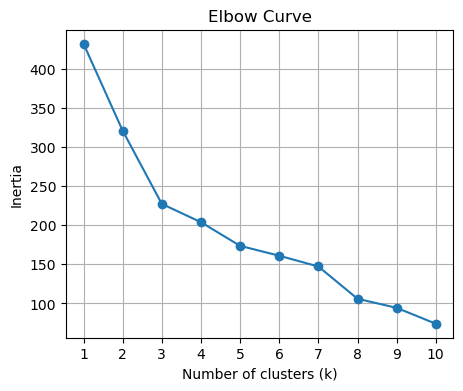

In [16]:
#elbow plot
df_microwave_filt1 = df_microwave[
    (df_microwave["cu_ft"] != "unknown") & 
    (df_microwave["recent_sales_num"].notna())
].copy()

df_microwave_filt1["cu_ft"] = df_microwave_filt1["cu_ft"].astype(float)

features_a = df_microwave_filt1[["rating", "ratings_total", "cu_ft", 
                                 "recent_sales_num", "discount$", "discount%"]].fillna(0)

scaler = StandardScaler()
features_a_scaled = scaler.fit_transform(features_a)

k_range = range(1, 11)
inertias = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_a_scaled)
    inertias.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(5, 4))
plt.plot(k_range, inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Curve')
plt.xticks(k_range)
plt.grid(True)
plt.savefig("images/2/elbow_micro.png", dpi=300, bbox_inches='tight')
plt.show()

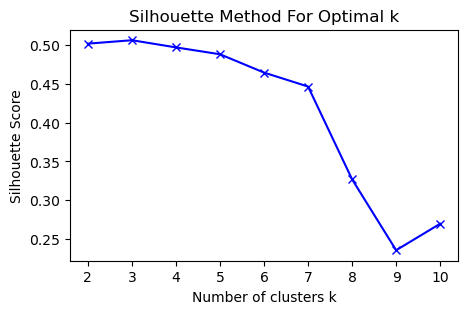

In [17]:
from sklearn.metrics import silhouette_score

sil_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(features_a_scaled)
    score = silhouette_score(features_a_scaled, labels)
    sil_scores.append(score)

plt.figure(figsize=(5,3))
plt.plot(K, sil_scores, 'bx-')
plt.xlabel('Number of clusters k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method For Optimal k')
plt.savefig("images/2/silh_micro.png", dpi=300, bbox_inches='tight')
plt.show()

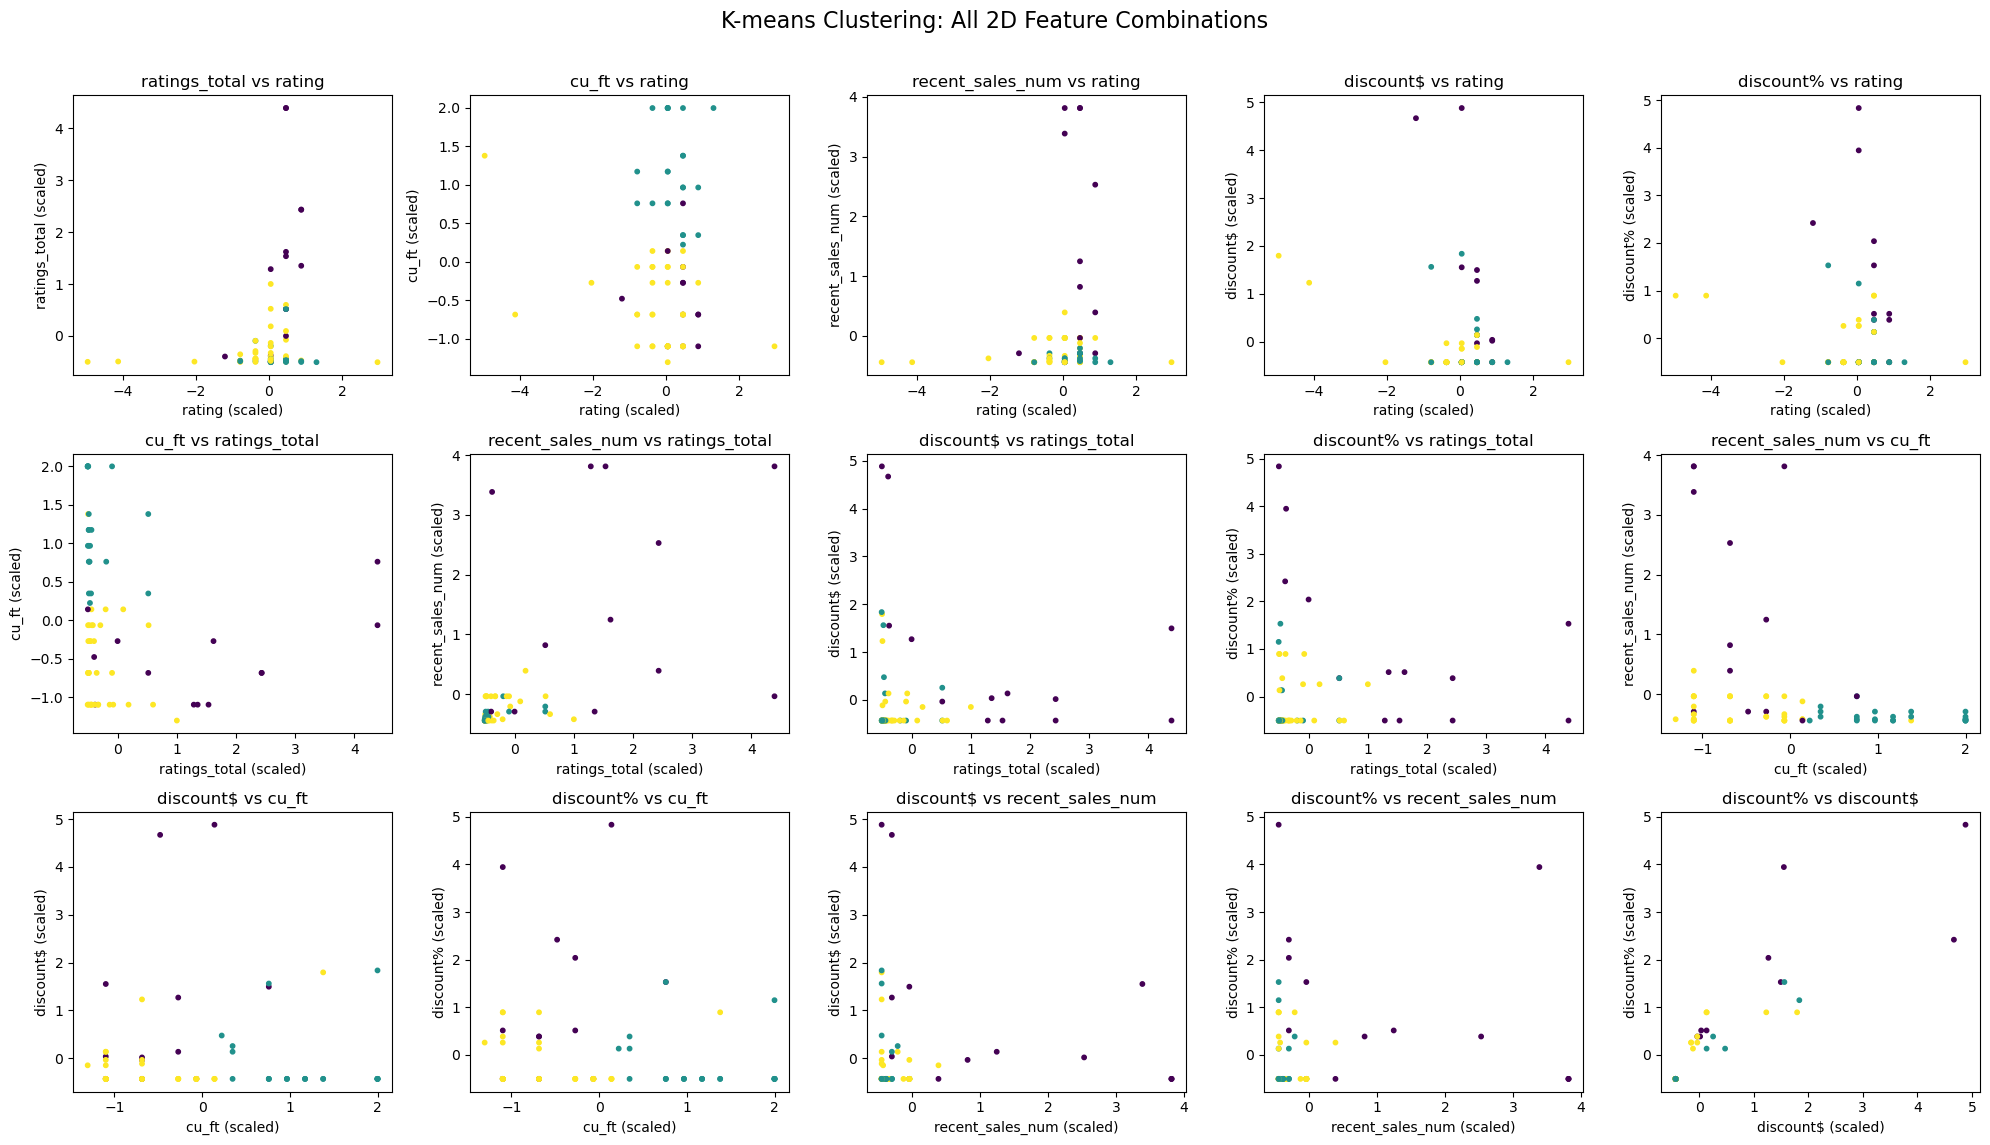

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import itertools
import math

# K-means
kmeans = KMeans(n_clusters=3, random_state=1216)
df_microwave_filt1["k_cluster"] = kmeans.fit_predict(features_a_scaled)

combinations = list(itertools.combinations(features_a.columns, 2))
n_plots = len(combinations)
n_cols = 5
n_rows = math.ceil(n_plots / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))
axes = axes.flatten()

col_index = {col: i for i, col in enumerate(features_a.columns)}
for idx, (x_col, y_col) in enumerate(combinations):
    ax = axes[idx]
    x_idx = col_index[x_col]
    y_idx = col_index[y_col]
    ax.scatter(features_a_scaled[:, x_idx], features_a_scaled[:, y_idx], c=df_microwave_filt1['k_cluster'], cmap='viridis', s=10)
    ax.set_xlabel(f'{x_col} (scaled)')
    ax.set_ylabel(f'{y_col} (scaled)')
    ax.set_title(f'{y_col} vs {x_col}')

# Hide unused subplots if any
for k in range(len(combinations), len(axes)):
    axes[k].axis('off')

fig.suptitle('K-means Clustering: All 2D Feature Combinations', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

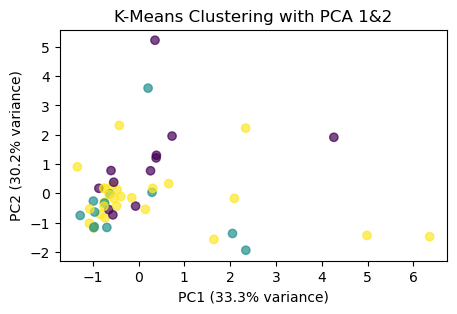

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

# Fit PCA to the scaled features and transform them
principal_components = pca.fit_transform(features_a_scaled)

# Create a DataFrame for the principal components for easier plotting
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Add the K-means cluster labels to the PCA DataFrame
pca_df['k_cluster'] = df_microwave_filt1['k_cluster']

explained_var = pca.explained_variance_ratio_

# 2. Plot the first two principal components
plt.figure(figsize=(5, 3))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['k_cluster'], cmap='viridis', alpha=0.7)
plt.xlabel(f"PC1 ({explained_var[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({explained_var[1]*100:.1f}% variance)")
plt.title('K-Means Clustering with PCA 1&2')
plt.savefig("images/2/kmeans_wPCA_micro.png", dpi=300, bbox_inches='tight')
plt.show()

In [20]:
cluster_summary = df_microwave_filt1.groupby("k_cluster")[["rating", "ratings_total", "cu_ft", "recent_sales_num", 
                                                           "discount$", "discount%"]].agg(["mean", "count"]).round(2)
cluster_summary

rating       ratings_total       cu_ft       recent_sales_num        \
            mean count          mean count  mean count             mean count   
k_cluster                                                                       
0           4.37    13      21575.69    13  0.98    13          4403.85    13   
1           4.34    23       1531.48    23  1.81    23           217.39    23   
2           4.23    36       2488.33    36  0.95    36           444.44    36   

          discount$       discount%        
               mean count      mean count  
k_cluster                                  
0             24.30    13      0.13    13  
1              4.93    23      0.02    23  
2              3.28    36      0.02    36

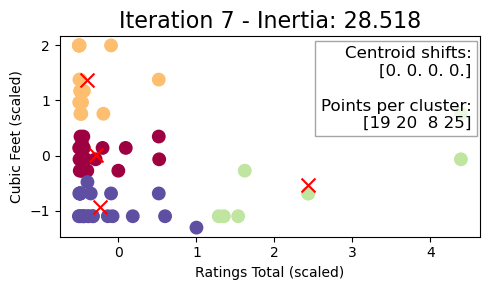

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

X_raw = df_microwave_filt1[["ratings_total", "cu_ft"]].values
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)
fig, ax = plt.subplots(figsize=(5,3))
k = 4
km = KMeans(n_clusters=k, init='random', n_init=1, max_iter=1, random_state=1)
centers_prev = None

def update(i):
    global km, centers_prev
    ax.clear()
    if i == 0:
        labels = np.random.randint(0, k, size=X.shape[0])
        ax.scatter(X[:,0], X[:,1], c=labels, cmap='Spectral', s=80)
        ax.set_title('Random labels', fontsize=16)
        centers_prev = None
        inertia = np.nan
        shifts = [0]*k
        counts = [0]*k
    else:
        if i == 1:
            km.fit(X)
        else:
            km = KMeans(n_clusters=k, init=km.cluster_centers_, n_init=1, max_iter=1, random_state=1)
            km.fit(X)
        labels = km.labels_
        centers = km.cluster_centers_
        inertia = km.inertia_
        if centers_prev is None:
            shifts = [0]*k
        else:
            shifts = np.linalg.norm(centers - centers_prev, axis=1)
        centers_prev = centers.copy()
        counts = np.bincount(labels, minlength=k)
        ax.scatter(X[:,0], X[:,1], c=labels, cmap='Spectral', s=80)
        ax.scatter(centers[:,0], centers[:,1], color='red', marker='x', s=100)
        ax.set_title(f"Iteration {i} - Inertia: {inertia:.3f}", fontsize=16)

    ax.set_xlabel("Ratings Total (scaled)")
    ax.set_ylabel("Cubic Feet (scaled)")

    # Show centroid shifts and cluster sizes inside plot area, top-right
    info_text = f"Centroid shifts:\n{np.round(shifts,3)}\n\nPoints per cluster:\n{counts}"
    ax.text(0.98, 0.95, info_text, transform=ax.transAxes,
            fontsize=12, verticalalignment='top', horizontalalignment='right',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))
    plt.tight_layout()
    return ax.collections

anim = FuncAnimation(fig, update, frames=8, interval=1000, blit=False)
from matplotlib.animation import PillowWriter
anim.save('images/2/kmeans_micro.gif', writer=PillowWriter(fps=1))
plt.show()

### Hierarchy

#### iPhones

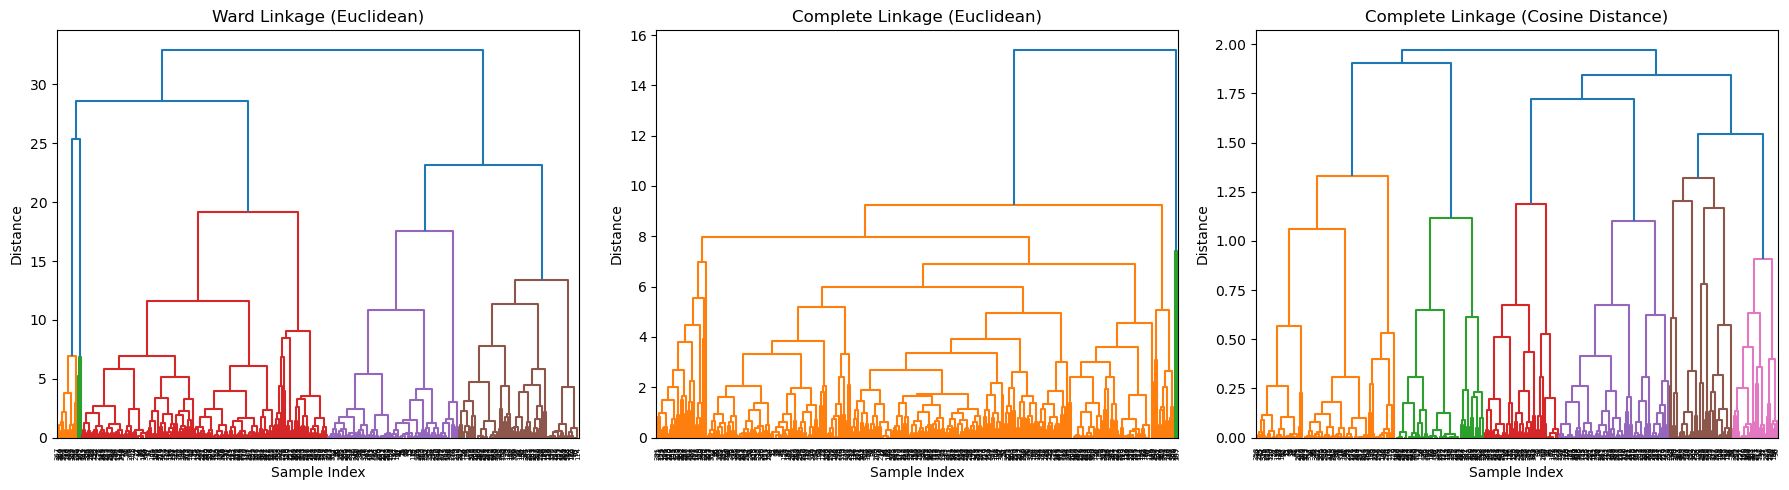

In [22]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

linked_ward = linkage(features_scaled, method="ward")
linked_comp = linkage(features_scaled, method="complete")
cosine_dist = pdist(features_scaled, metric='cosine')
linked_cosine_comp = linkage(cosine_dist, method='complete')

fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

# Ward linkage dendrogram
dendrogram(linked_ward,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True,
           ax=axs[0])
axs[0].set_title('Ward Linkage (Euclidean)')
axs[0].set_xlabel('Sample Index')
axs[0].set_ylabel('Distance')

# Complete linkage dendrogram
dendrogram(linked_comp,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True,
           ax=axs[1])
axs[1].set_title('Complete Linkage (Euclidean)')
axs[1].set_xlabel('Sample Index')
axs[1].set_ylabel('Distance')

# Comp linkage dendrogram (Cosine distance)
dendrogram(linked_cosine_comp,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True,
           ax=axs[2])
axs[2].set_title('Complete Linkage (Cosine Distance)')
axs[2].set_xlabel('Sample Index')
axs[2].set_ylabel('Distance')

plt.tight_layout()
plt.savefig("images/2/dendogram_iphone.png", dpi=300, bbox_inches='tight')
plt.show()

In [23]:
from scipy.cluster.hierarchy import fcluster

#3 clusters from Ward
num_clusters_ward = 3
labels_ward = fcluster(linked_ward, num_clusters_ward, criterion='maxclust')
filtered_df_iphone["h_cluster_ward"] = labels_ward

#6 clusters from cosine complete
num_clusters_cosine = 6
labels_cosine = fcluster(linked_cosine_comp, num_clusters_cosine, criterion='maxclust')
filtered_df_iphone["h_cluster_cosine_comp"] = labels_cosine

In [24]:
print(filtered_df_iphone["h_cluster_ward"].value_counts())
filtered_df_iphone.groupby("h_cluster_ward")[["seller.feedbackPercentage", "seller.feedbackScore", 
                           "days_listed", "shipping_cost", "seller_item_count",
                           "additional_image_count", "title_length"]].mean().round(2)



h_cluster_ward
1    186
2    182
3     18
Name: count, dtype: int64


,seller.feedbackPercentage,seller.feedbackScore,days_listed,shipping_cost,seller_item_count,additional_image_count,title_length
h_cluster_ward,,,,,,,
1,98.23,124662.46,391.91,0.00,34.43,1.49,63.48
2,98.40,12387.76,110.40,0.22,7.06,3.37,66.04
3,11.11,73.00,110.39,4.86,1.00,2.33,47.22


In [25]:
print(filtered_df_iphone["h_cluster_cosine_comp"].value_counts())
filtered_df_iphone.groupby("h_cluster_cosine_comp")[["seller.feedbackPercentage", "seller.feedbackScore", 
                           "days_listed", "shipping_cost", "seller_item_count",
                           "additional_image_count", "title_length"]].mean().round(2)

h_cluster_cosine_comp
6    103
3     82
5     66
4     55
2     46
1     34
Name: count, dtype: int64


,seller.feedbackPercentage,seller.feedbackScore,days_listed,shipping_cost,seller_item_count,additional_image_count,title_length
h_cluster_cosine_comp,,,,,,,
1,97.75,12494.24,183.29,0.00,3.74,9.97,62.24
2,64.53,20887.48,166.07,2.45,2.20,2.80,47.65
3,98.57,10791.90,88.90,0.18,6.34,3.26,74.72
4,98.43,13911.35,129.05,0.00,11.22,0.65,61.15
5,98.16,71120.70,636.85,0.00,26.06,1.33,71.18
6,98.18,171975.23,239.65,0.00,44.87,0.73,60.01


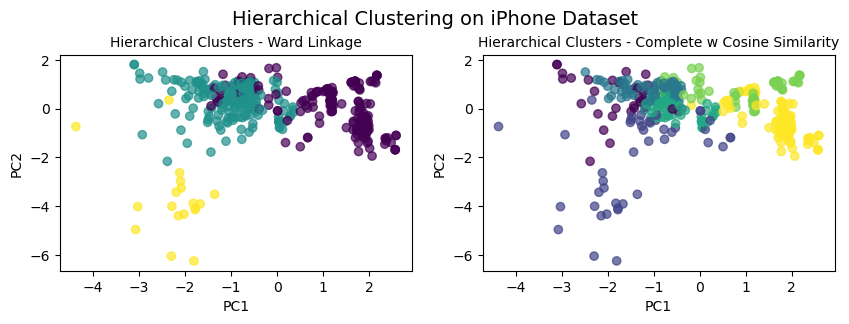

In [26]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(features_scaled)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].scatter(pca_df["PC1"], pca_df["PC2"], 
            c=filtered_df_iphone["h_cluster_ward"], cmap="viridis", alpha=0.7)
axs[0].set_xlabel("PC1")
axs[0].set_ylabel("PC2")
axs[0].set_title("Hierarchical Clusters - Ward Linkage", fontsize=10)

axs[1].scatter(pca_df["PC1"], pca_df["PC2"], 
            c=filtered_df_iphone["h_cluster_cosine_comp"], cmap="viridis", alpha=0.7)
axs[1].set_xlabel("PC1")
axs[1].set_ylabel("PC2")
axs[1].set_title("Hierarchical Clusters - Complete w Cosine Similarity", fontsize=10)
fig.suptitle("Hierarchical Clustering on iPhone Dataset", fontsize=14)
plt.subplots_adjust(top=0.83)
plt.savefig("images/2/hclust_iphone.png", dpi=300, bbox_inches='tight', facecolor="#E7E7E7")
plt.show()


#### Soccer (added later)

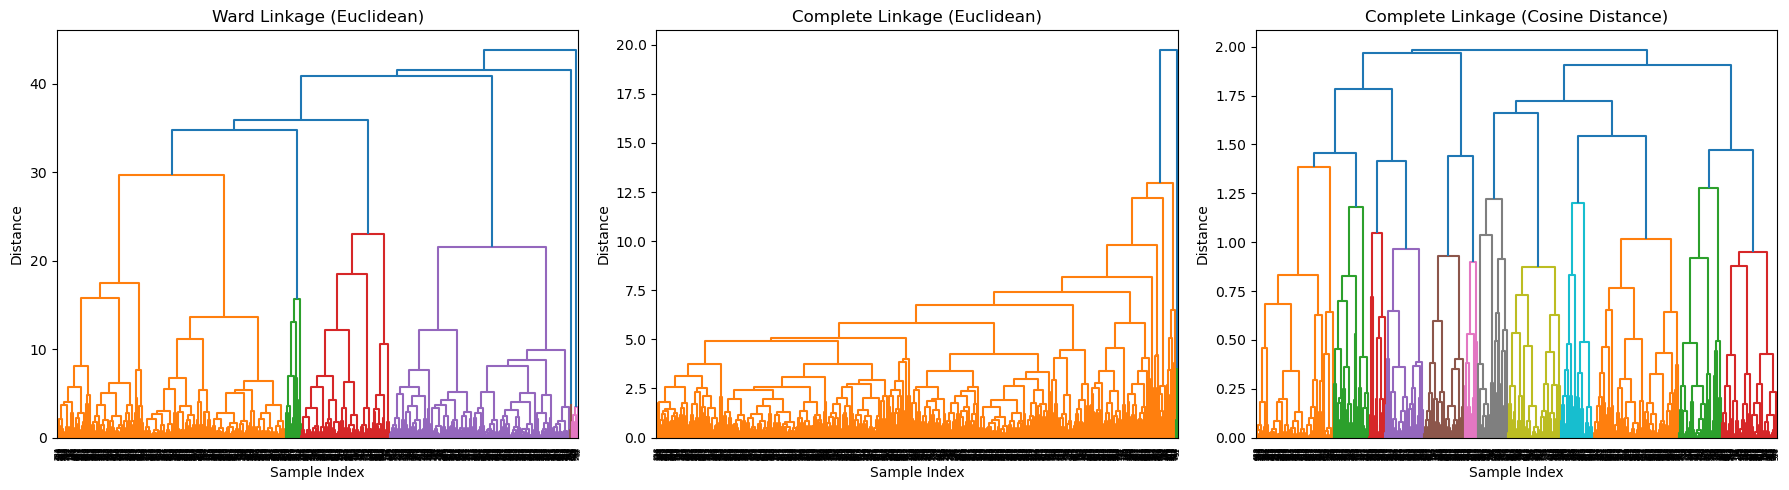

In [27]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

linked_ward = linkage(features_soccer_scaled, method="ward")
linked_comp = linkage(features_soccer_scaled, method="complete")
cosine_dist = pdist(features_soccer_scaled, metric='cosine')
linked_cosine_comp = linkage(cosine_dist, method='complete')

fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

# Ward linkage dendrogram
dendrogram(linked_ward,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True,
           ax=axs[0])
axs[0].set_title('Ward Linkage (Euclidean)')
axs[0].set_xlabel('Sample Index')
axs[0].set_ylabel('Distance')

# Complete linkage dendrogram
dendrogram(linked_comp,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True,
           ax=axs[1])
axs[1].set_title('Complete Linkage (Euclidean)')
axs[1].set_xlabel('Sample Index')
axs[1].set_ylabel('Distance')

# Comp linkage dendrogram (Cosine distance)
dendrogram(linked_cosine_comp,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True,
           ax=axs[2])
axs[2].set_title('Complete Linkage (Cosine Distance)')
axs[2].set_xlabel('Sample Index')
axs[2].set_ylabel('Distance')

plt.tight_layout()
plt.savefig("images/2/dendogram_soccer.png", dpi=300, bbox_inches='tight')
plt.show()

In [28]:
from scipy.cluster.hierarchy import fcluster

#3 clusters from Ward
num_clusters_ward = 4
labels_ward = fcluster(linked_ward, num_clusters_ward, criterion='maxclust')
df_soccer["h_cluster_ward"] = labels_ward

#6 clusters from cosine complete
num_clusters_cosine = 4
labels_cosine = fcluster(linked_cosine_comp, num_clusters_cosine, criterion='maxclust')
df_soccer["h_cluster_cosine_comp"] = labels_cosine

In [29]:
print(df_soccer["h_cluster_ward"].value_counts())
df_soccer.groupby("h_cluster_ward")[["seller.feedbackPercentage", "seller.feedbackScore", 
                           "days_listed", "shipping_cost", "seller_item_count",
                           "additional_image_count", "title_length"]].mean().round(2)

h_cluster_ward
4    638
3    346
1     13
2      3
Name: count, dtype: int64


,seller.feedbackPercentage,seller.feedbackScore,days_listed,shipping_cost,seller_item_count,additional_image_count,title_length
h_cluster_ward,,,,,,,
1,0.00,0.00,20.62,0.77,2.69,3.69,68.15
2,98.33,626132.00,233.00,3.99,1.67,2.00,56.00
3,98.19,1287.82,149.17,3.81,6.68,2.76,42.35
4,98.51,3354.50,220.66,2.93,6.42,6.85,70.58


In [30]:
print(df_soccer["h_cluster_cosine_comp"].value_counts())
df_soccer.groupby("h_cluster_cosine_comp")[["seller.feedbackPercentage", "seller.feedbackScore", 
                           "days_listed", "shipping_cost", "seller_item_count",
                           "additional_image_count", "title_length"]].mean().round(2)

h_cluster_cosine_comp
2    386
4    322
1    189
3    103
Name: count, dtype: int64


,seller.feedbackPercentage,seller.feedbackScore,days_listed,shipping_cost,seller_item_count,additional_image_count,title_length
h_cluster_cosine_comp,,,,,,,
1,97.60,399.19,117.66,0.61,15.71,7.41,60.27
2,98.63,9891.05,250.82,0.24,3.59,4.28,62.99
3,98.95,2109.17,265.86,4.96,4.05,13.48,71.83
4,94.42,1097.87,145.72,7.73,5.20,2.92,54.77


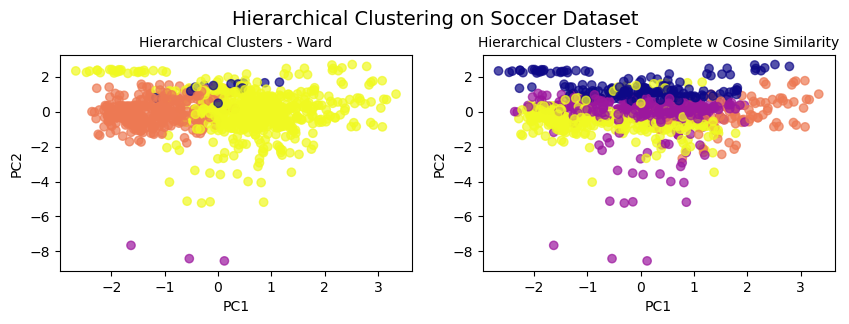

In [31]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(features_soccer_scaled)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

# First plot
axs[0].scatter(pca_df["PC1"], pca_df["PC2"], 
               c=df_soccer["h_cluster_ward"], cmap="plasma", alpha=0.7)
axs[0].set_title("Hierarchical Clusters - Ward", fontsize=10)
axs[0].set_xlabel("PC1")
axs[0].set_ylabel("PC2")

# Second plot
axs[1].scatter(pca_df["PC1"], pca_df["PC2"], 
               c=df_soccer["h_cluster_cosine_comp"], cmap="plasma", alpha=0.7)
axs[1].set_title("Hierarchical Clusters - Complete w Cosine Similarity", fontsize=10)
axs[1].set_xlabel("PC1")
axs[1].set_ylabel("PC2")
fig.suptitle("Hierarchical Clustering on Soccer Dataset", fontsize=14)
plt.subplots_adjust(top=0.83)
plt.savefig("images/2/hclust_soccer.png", dpi=300, bbox_inches="tight", facecolor="#E7E7E7")
plt.show()

### KPrototype

kproto_cluster
2    182
0    118
1     86
Name: count, dtype: int64
[['456.90550847457615' '545.9067796610169' 'no_carrier'
  '2020 - Very Good - Refurbished']
 ['866.9975581395341' '126.05813953488372' 'no_carrier'
  '2020 - Very Good - Refurbished']
 ['471.39675824175833' '108.33516483516483' 'no_carrier' '3000 - Used']]


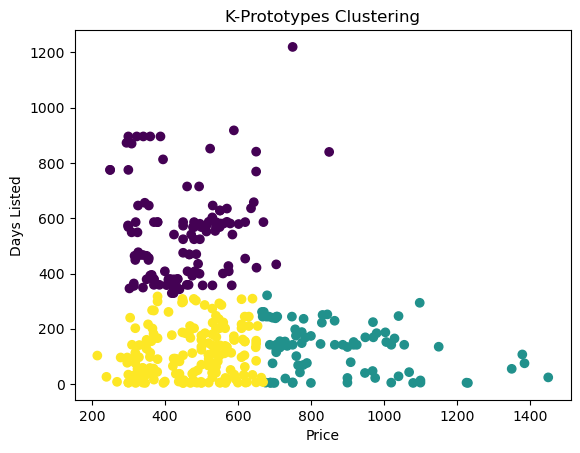

In [32]:
from kmodes.kprototypes import KPrototypes

numeric_features = ["price.value", "days_listed"]
categorical_features = ["specific_carrier", "condition_desc"]
df_for_cluster = filtered_df_iphone[numeric_features + categorical_features].copy()

df_for_cluster[numeric_features] = df_for_cluster[numeric_features].fillna(0)
df_for_cluster[categorical_features] = df_for_cluster[categorical_features].fillna("missing")
df_for_cluster['price.value'] = df_for_cluster['price.value'].astype(float)
df_for_cluster['days_listed'] = df_for_cluster['days_listed'].astype(float)

X = df_for_cluster.to_numpy()

cat_cols = [df_for_cluster.columns.get_loc(col) for col in categorical_features]

kproto = KPrototypes(n_clusters=3, random_state=42)
labels = kproto.fit_predict(X, categorical=cat_cols)

filtered_df_iphone["kproto_cluster"] = labels

print(filtered_df_iphone["kproto_cluster"].value_counts())
print(kproto.cluster_centroids_)
import matplotlib.pyplot as plt

plt.scatter(
    filtered_df_iphone["price.value"], 
    filtered_df_iphone["days_listed"], 
    c=filtered_df_iphone["kproto_cluster"], 
    cmap='viridis'
)
plt.xlabel("Price")
plt.ylabel("Days Listed")
plt.title("K-Prototypes Clustering")
plt.show()


In [33]:
print(df_for_cluster.info())
print(df_for_cluster.isna().sum())
print(df_for_cluster.applymap(type).nunique())

<class 'pandas.core.frame.DataFrame'>
Index: 386 entries, 0 to 475
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price.value       386 non-null    float64
 1   days_listed       386 non-null    float64
 2   specific_carrier  386 non-null    object 
 3   condition_desc    386 non-null    object 
dtypes: float64(2), object(2)
memory usage: 23.2+ KB
None
price.value         0
days_listed         0
specific_carrier    0
condition_desc      0
dtype: int64
price.value         1
days_listed         1
specific_carrier    1
condition_desc      1
dtype: int64


/var/folders/vg/bxzl7hss0gs1hqxsc9zj92l80000gn/T/ipykernel_3113/13504498.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(df_for_cluster.applymap(type).nunique())
